### Settings

In [ ]:
TRAIN_RUN = True
TEST_RUN = not TRAIN_RUN
FIRST_TIME = False
EPOCHS_NUM = 50

### Download Data from Kaggle
see - https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/PyTorchPractice"
# /content/gdrive/My Drive/Colab Notebook/PyTorchPractice is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/drive/MyDrive/'Colab Notebooks'/PyTorchPractice/FacialKeypointsDetectionData

/content/drive/MyDrive/Colab Notebooks/PyTorchPractice/FacialKeypointsDetectionData


## Get data

#### First time only


In [ ]:
#!kaggle competitions download -c facial-keypoints-detection

In [ ]:
# %cd ./FacialKeypointsDetectionData
# !unzip ./training.zip -d train
!ls

FacialKeypointsDetector.pth  Submission.csv  train		 training.zip
IdLookupTable.csv	     test.csv	     training_clean.csv
kaggle.json		     test.png	     training.csv
SampleSubmission.csv	     test.zip	     training_fixed.csv


#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import random

Preprocess Data

In [ ]:
training_csv_name = 'training.csv'
training_csv_name_clean = 'training_clean.csv'
training_csv_name_fixed = 'training_fixed.csv'
df = pd.read_csv('training.csv')
df.head(1)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [ ]:
df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [ ]:
print(list(df.columns))
df.info()

['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   

we can see many missing keypoints

In [ ]:
def show_keypoints(image, key_pts, mask=None):
    """Show image with keypoints"""    
    if image.ndim == 3 and image.shape[0] > 1:
        if type(image) == torch.Tensor:
            plt.imshow(image.permute(1, 2, 0), )    
        else:
            plt.imshow(image, )    
    else:
        plt.imshow(image.squeeze(), cmap='gray',)        
    norm = image.shape[-1] if key_pts.flatten()[0] <= 1 else 1
    if mask is not None:        
        key_pts = np.array([a for a, b in zip(key_pts.flatten(), mask.flatten()) if b]).reshape(-1,2)        
    plt.scatter(key_pts[:, 0]*norm, key_pts[:, 1]*norm, s=10, marker='.', c='m')

#### show a sample - image with key points

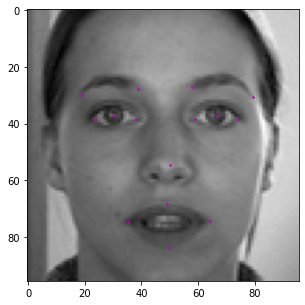

In [ ]:
# draw given feature points over an image
img_inx = 12
image = df['Image'][img_inx]
# image is a string
image = image.split()
img_size = int(len(image) ** 0.5) # 96
# now image is a list
image = np.array(image,dtype=np.uint8)
# image is a numpy arrary
image = image.reshape(img_size,img_size)
key_pts = df.iloc[img_inx,:-1].to_numpy().reshape(-1,2)
plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)
plt.show()

###Handle missing Data

#### create a key points mask for valid points

In [ ]:
valid_mask = df.notna()
valid_mask = valid_mask.to_numpy(dtype = 'int')
valid_mask = valid_mask[:,:30] # keypoints only mask
valid_mask = [" ".join(l.astype(str)) for l in valid_mask]

# add the mask as a new column on the dataframe
new_df = df
new_df['valid keys'] = valid_mask

In [ ]:
new_df.iloc[3476 ]

left_eye_center_x                                                       66.283
left_eye_center_y                                                      42.1721
right_eye_center_x                                                     32.7362
right_eye_center_y                                                     39.7947
left_eye_inner_corner_x                                                    NaN
left_eye_inner_corner_y                                                    NaN
left_eye_outer_corner_x                                                    NaN
left_eye_outer_corner_y                                                    NaN
right_eye_inner_corner_x                                                   NaN
right_eye_inner_corner_y                                                   NaN
right_eye_outer_corner_x                                                   NaN
right_eye_outer_corner_y                                                   NaN
left_eyebrow_inner_end_x                            

#### create new dataframes with/without missing values

In [ ]:
# Data cleanup - remove rows with missing data
clean_df = new_df.dropna(axis='rows')   
clean_df.to_csv(training_csv_name_clean, index = False)

fixed_df = new_df.fillna(method='ffill')
fixed_df.to_csv(training_csv_name_fixed, index = False)

### Data Loader


In [ ]:
# inspired from https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
from torch.utils.data import Dataset, DataLoader
class FacialKeypointsDataset():
    """Face Landmarks dataset."""
    def __init__(self, csv_file, root_dir=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)        
        self.transform = transform      
    def __len__(self):
        return len(self.df)     
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        IM_DIM = 96
        image = self.df['Image'][idx]        
        image = image.split()        
        image = np.array(image,dtype=np.float)/255
        image = image.reshape(IM_DIM,IM_DIM)        
        image = np.stack((image,image,image),axis=-1) # create 3 channel image        
        landmarks = self.df.iloc[idx, 0:30]        
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)/IM_DIM    
        landmarks_mask = self.df.iloc[idx, 31]        
        landmarks_mask = landmarks_mask.split()
        landmarks_mask = np.array(landmarks_mask,dtype=np.int).reshape(-1,2)

        sample = {'image': image, 'key_pts': landmarks, 'mask': landmarks_mask}

        if self.transform:
            sample = self.transform(sample)

        return sample             

#### create transforms

In [ ]:
from torchvision import transforms
from math import cos, sin, pi

class facialRotation:
    def __init__(self, angle):
        assert angle <= 1.0 and angle >=0
        self.angle = angle
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        rotVal = random.uniform(-self.angle, self.angle)        
        newImg = transforms.functional.rotate(img, angle=-rotVal*180/pi)
        teta = rotVal
        rotMat = np.array([[cos(teta), sin(teta)],[-sin(teta), cos(teta)]])
        newKeyPts = np.dot(keyPts-[0.5,0.5],rotMat)+[0.5,0.5]
        return {'image':newImg.float(), 'key_pts': newKeyPts, 'mask': mask}

class toTensor:
    def __init__(self):
        pass
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        imgToTensor = transforms.ToTensor()
        newImg = imgToTensor(img)
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class horizFlip:
    def __init__(self, p):
        self.p = p
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']       
        if random.random() < self.p :
            newImg = transforms.functional.hflip(img)       
            newKeyPts = keyPts
            print('old\n', keyPts)
            newKeyPts[:,0] = 1-newKeyPts[:,0]
            print('new\n', newKeyPts)            
        else:
            newImg = img
            newKeyPts = keyPts
        return {'image':newImg.float(), 'key_pts': newKeyPts, 'mask': mask}

class randomBrightness:
    def __init__(self):
        pass
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']         
        brightnessFact = 0.5*random.random()+0.75 #uniform ~[0.75,1.25]
        newImg = transforms.functional.adjust_brightness(img, brightnessFact)        
        # newKeyPts = keyPts
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}

class GaussianBlur:
    def __init__(self, kernel):
        self.kernel = kernel
    def __call__(self, sample):
        img, keyPts, mask = sample['image'], sample['key_pts'], sample['mask']             
        newImg = transforms.GaussianBlur(self.kernel)(img)
        return {'image':newImg.float(), 'key_pts': keyPts, 'mask': mask}


In [ ]:
# transforms pipeline
data_transform = transforms.Compose([
    toTensor(), # must stay in order to convert to range[0,1]    
    randomBrightness(),
    GaussianBlur(3),
    # horizFlip(0.5),
    facialRotation(0.1),        
])

#### Instantiate dataset and visualize

In [ ]:
def show_batch_samples(batch, number=8 ,ordered=True, dataloader=False):
    fig = plt.figure(figsize=(min(number,8)*3,5*number/8))
    i=0
    batch_list = batch
    # if dataloader: batch_list = zip(batch['image'], batch['key_pts'], batch['mask'])
    while i < number:
        img_inx=i
        if not ordered:
            img_inx = random.randrange(len(face_dataset))
        if dataloader:
            sample={}
            sample['image'], sample['key_pts'], sample['mask'] = batch['image'][img_inx], batch['key_pts'][img_inx], batch['mask'][img_inx]
        else:
            sample = batch_list[img_inx]    
        # print('image #',img_inx, sample['image'].shape, sample['key_pts'].shape, sum(sample['mask'].flatten())//2,'points')
        if sample['key_pts'].ndim == 1: continue
        ax = plt.subplot(number/8, min(number,8), i + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(img_inx))
        ax.axis('off')            
        show_keypoints(sample['image'], sample['key_pts'], sample['mask'])
        i+=1

    plt.show()    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


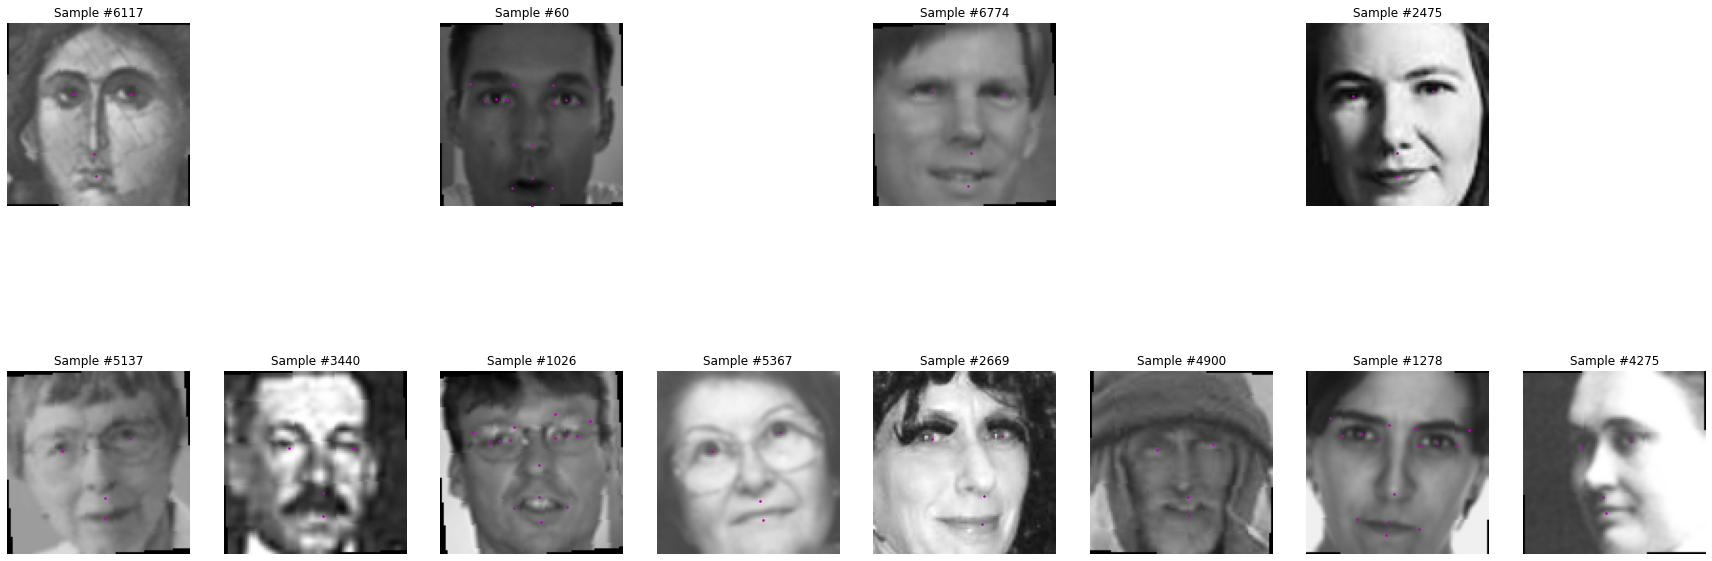

In [ ]:
face_dataset = FacialKeypointsDataset(csv_file=training_csv_name_fixed, transform = data_transform)

show_batch_samples(face_dataset, number=16 ,ordered=False, dataloader=False)

# fig = plt.figure(figsize=(10,40))
# i=0
# while i < 4:
#     img_inx = random.randrange(len(face_dataset))
#     sample = face_dataset[img_inx]    
#     # print('image #',img_inx, sample['image'].shape, sample['key_pts'].shape, sum(sample['mask'].flatten())//2,'points')
#     if sample['key_pts'].ndim == 1: continue
#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(img_inx))
#     ax.axis('off')            
#     show_keypoints(sample['image'], sample['key_pts'], sample['mask'])
#     i+=1

# plt.show()

#### create dataloder

In [ ]:
# split 80/20
split_ls = [int(0.8*len(face_dataset)), len(face_dataset) - int(0.8*len(face_dataset))]
train_set,val_set = torch.utils.data.random_split(face_dataset, split_ls)

batch_size=32
# dataloader = DataLoader(face_dataset, batch_size=1, shuffle=False, num_workers=0) # temporary
dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
dataloader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)

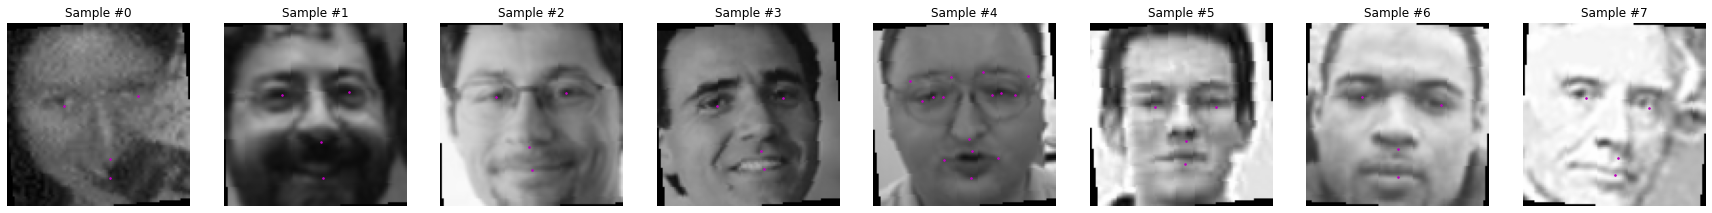

In [ ]:
#show dataloader next mini batch
data_sample = iter(dataloader).next()

show_batch_samples(data_sample, number=8 ,ordered=True, dataloader=True)

# samples, keysPts, mask = data_sample['image'], data_sample['key_pts'], data_sample['mask']
# print(samples.shape, keysPts.shape)
# fig = plt.figure(figsize=(10,40))
# for i in range(min(samples.shape[0],4)):    
#     print(i, samples[i].shape, keysPts[i].shape , sum(sample['mask'].flatten())//2,'points')    
#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()    
#     ax.axis('off')    
#     show_keypoints(samples[i], keysPts[i], mask[i])

## Model

#### Define custom Model 1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    toPrint = False
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)        
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, 1, 1)        
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, 3, 1, 1)        
        self.bn5 = nn.BatchNorm2d(256)        
        self.conv6 = nn.Conv2d(256, 256, 3, 1, 1)        
        self.bn6 = nn.BatchNorm2d(256)                
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.25)
        self.dropout4 = nn.Dropout(0.25)
        self.dropout5 = nn.Dropout(0.25)
        self.dropout6 = nn.Dropout(0.25)
        self.dropout7 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2304, 512)
        self.fc2 = nn.Linear(512, 30)
        self.BN = nn.BatchNorm2d

    def convBlock(self, x, in_maps, out_maps):
        out = out_maps
        conv1 = nn.Conv2d(in_maps, out, 3, 1, 1)
        bn1 = nn.BatchNorm2d(out)
        conv2 = nn.Conv2d(out, out, 3, 1, 1)        
        
        new_x = conv1(x)        
        new_x= bn1(new_x)
        new_x = self.dropout1(new_x)
        new_x = F.relu(new_x)
        new_x = conv2(new_x)        
        new_x= bn1(new_x)
        new_x = self.dropout1(new_x)
        new_x = F.relu(new_x)

    # def forward1(self, x):
    #     # (1,96,96)
    #     x = self.convBlock(x, 1, 16)
    #     x = F.max_pool2d(x, 2)
    #     # (16,48,48)
    #     x = convBlock(x, 16, 32) 
    #     x = F.max_pool2d(x, 2)
    #     # (32,24,24)
    #     x = convBlock(x, 32, 64) 
    #     x = F.max_pool2d(x, 2)
    #     # (64,12,12)
    #     x = convBlock(x, 64, 128) 
    #     x = F.max_pool2d(x, 2)
    #     # (128,6,6)
    #     x = convBlock(x, 128, 128)         
    #     # (128,6,6)
    #     x = torch.flatten(x, 1)
    #     # (2304)        
    #     x = self.fc1(x)
    #     x = F.relu(x)        
    #     x = self.dropout2(x)
    #     x = self.fc2(x)                
    #     x = x.reshape(-1,15,2)
    #     output = x        
    #     return output


    def forward(self, x):
        # x = x.
        # (1,96,96)
        if self.toPrint: print('input: ', x.shape) #, x)
        x = self.conv1(x)
        x = self.bn1(x)        
        x = self.dropout1(x)
        x = F.relu(x)
        if self.toPrint: print('conv1: ', x.shape) #, x)
        x = F.max_pool2d(x, 2)        
        # (16,48,48)
        x = self.conv2(x)
        x = self.bn2(x)        
        x = self.dropout2(x)                        
        x = F.relu(x)
        if self.toPrint: print('conv2: ', x.shape) # ,x)   
        x = F.max_pool2d(x, 2)                
        # (32,24,24)
        x = self.conv3(x)
        x = self.bn3(x)        
        x = self.dropout3(x)
        x = F.relu(x)     
        if self.toPrint: print('conv3: ', x.shape) # ,x)   
        x = F.max_pool2d(x, 2)
        # (64,12,12)
        x = self.conv4(x)
         # (128,12,12)
        x = self.bn4(x)        
        x = self.dropout4(x)        
        x = F.relu(x)
        if self.toPrint: print('conv4: ', x.shape) #, x)
        x = F.max_pool2d(x, 2)
        x = self.conv5(x)
        # (256,6,6)
        x = self.bn5(x)        
        x = self.dropout5(x)        
        x = F.relu(x)
        if self.toPrint: print('conv5: ', x.shape) #, x)        
        x = F.max_pool2d(x, 2)                
        # (256,3,3)
        x = self.dropout6(x)
        # print('conv5 ', x.shape) # ,x)           
        x = torch.flatten(x, 1)
        # (2304)        
        x = self.fc1(x)
        x = F.relu(x)
        if self.toPrint: print('fc1: ', x.shape ,x)   
        x = self.dropout7(x)
        x = self.fc2(x)        
        if self.toPrint: print('fc2: ', x.shape ,x)   
        x = x.reshape(-1,15,2)
        output = x
        # output = F.log_softmax(x, dim=1)
        return output

custom_model1 = NeuralNetwork()
print(custom_model1)

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

#### Define Custom model 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# can use the below import should you choose to initialize the weights of your Net
import torch.nn.init as I

class Net2(nn.Module):

    def __init__(self):
        super(Net2, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        
        #obejctive is to bring down the image size to single unit-->
        #here given image size is 224x224px
        self.conv1 = nn.Conv2d(1, 32, 5)
        #224--> 224-5+1=220
        self.pool1 = nn.MaxPool2d(2, 2)
        #220/2=110 ...(32,110,110)
        
        self.conv2 = nn.Conv2d(32, 64, 3)
        #110--> 110-3+1=108
        self.pool2 = nn.MaxPool2d(2, 2)
        #108/2=54
        
        self.conv3 = nn.Conv2d(64, 128, 3)
        #54-->54-3+1=52
        self.pool3 = nn.MaxPool2d(2, 2)
        #52/2=26
        
        self.conv4 = nn.Conv2d(128, 256, 3)
        #26-->26-3+1=24
        self.pool4 = nn.MaxPool2d(2, 2)
        #24/2=12
        
        self.conv5 = nn.Conv2d(256,512,1)
        #12-->12-1+1=12
        self.pool5 = nn.MaxPool2d(2,2)
        #12/2=6
        
        #6x6x512
        self.fc1 = nn.Linear(2*2*512 , 1024)
#         self.fc2 = nn.Linear(1024,1024)
        self.fc2 = nn.Linear(1024,30)
        
        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.3)
        self.drop4 = nn.Dropout(p = 0.4)
        self.drop5 = nn.Dropout(p = 0.5)
        self.drop6 = nn.Dropout(p = 0.6)
        #self.fc2_drop = nn.Dropout(p=.5)            
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        # print('conv2: ', x.shape) 
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        # print('conv2: ', x.shape) 
        x = self.drop3(self.pool3(F.relu(self.conv3(x))))
        # print('conv3: ', x.shape) 
        x = self.drop4(self.pool4(F.relu(self.conv4(x))))
        # print('conv4: ', x.shape) 
        x = self.drop5(self.pool5(F.relu(self.conv5(x))))
        # print('conv5: ', x.shape) 
        x = x.view(x.size(0), -1)
        # print('fc1: ', x.shape) 
        x = self.drop6(F.relu(self.fc1(x)))
        x = self.fc2(x)       

        x = x.reshape(-1,15,2)       
        
        # a modified x, having gone through all the layers of your model, should be returned
        return x
custom_model2 = Net2()
print(custom_model2)

Net2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=30, bias=True)
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (dro

#### Use pretrained model - Resnet18

In [ ]:
import torchvision.models as models
import torch.nn as nn
resnet_model = models.resnet18(pretrained = True)

# add clasifier for 30 outputs
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 30)
# model2.fc = nn.Sequential(
#         nn.Linear(num_ftrs, 30),
#         torch.reshape((-1,15,2))
# )

### Train Model

#### Define training function

In [ ]:
def testing(dataloader_val, print_en=False):
    ''' calulates the loss over validation set '''    
    model.eval()
    total_loss = 0        
    for sample in dataloader_val: # run over the mini batches            
        images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']
        images, keysPts, mask = images.to(device), keysPts.to(device), mask.to(device)           
        output = model(images)  
        output = output.view(-1, 15, 2)          
        loss = criterion(output, keysPts.float(), mask)            
        total_loss += loss.item()
    
    return total_loss/(len(dataloader_val))


def train_model(dataloader_train, dataloader_val, epochs=3, print_en=False):
    ''' train and test model given train dataloader, validation dataloader and epochs number '''
    itr = 1
    model.train()     
    # p_itr = 20        
    loss_list, val_loss_list = [], []    
    for epoch in range(epochs):
        total_loss = 0
        # itr_loss = 0
        model.train()        
        for sample in dataloader_train: # run over the mini batches
            # if print_en: print("######## itr = ", itr)
            images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']
            # get the inputs; data is a list of (inputs, keysPts, masks)
            images, keysPts, mask = images.to(device), keysPts.to(device), mask.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            output = model(images) 
            output = output.view(-1, 15, 2)                    
            loss = criterion(output, keysPts.float(), mask)            
            loss.backward()
            optimizer.step()                    
            total_loss += loss.item()          

        loss_list.append(total_loss/(len(dataloader_train)))
        val_loss = testing(dataloader_val,False)
        print('[Epoch {}/{}] -> train loss: {:.8f}  Validation Loss: {:.8f}; Validation RMSE: {:.4f}'\
                        .format(epoch+1, epochs, loss_list[-1], val_loss, 96*(val_loss**0.5)))
        val_loss_list.append(val_loss)

    print('Finished Training')
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.plot(loss_list, label='train loss')
    ax1.plot(val_loss_list, label='val loss')    
    ax1.legend()
    ax1.set_title('Training and validation loss')
    val_acc_list = [96*(val_loss**0.5) for val_loss in val_loss_list]
    ax2.plot(val_acc_list, label='Validation RMSE')    
    ax2.set_title('Validation RMSE')
    fig.show()    


#### Choose training parameters

#### Choose Model

In [ ]:
model = custom_model1
# model = resnet_model
# model = custom_model2

In [ ]:
# torch.manual_seed(1)    # reproducible
# check GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
learning_rate=0.001

# Define Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
# create custom loss functino - MSE with mask
torch_MSE = torch.nn.MSELoss()
def masked_MSELoss(pred, gt, mask):    
    pred = pred * mask
    gt = gt * mask    
    return torch_MSE(pred, gt)

def non_masked_MSELoss(pred, gt, mask):    
    return torch_MSE(pred, gt)

criterion = non_masked_MSELoss

#### Train Model

[Epoch 1/50] -> train loss: 0.08338166  Validation Loss: 0.03139660; Validation RMSE: 17.0103
[Epoch 2/50] -> train loss: 0.02301370  Validation Loss: 0.01006018; Validation RMSE: 9.6288
[Epoch 3/50] -> train loss: 0.01783523  Validation Loss: 0.01419680; Validation RMSE: 11.4384
[Epoch 4/50] -> train loss: 0.01384471  Validation Loss: 0.00466668; Validation RMSE: 6.5581
[Epoch 5/50] -> train loss: 0.01009896  Validation Loss: 0.00717535; Validation RMSE: 8.1319
[Epoch 6/50] -> train loss: 0.00860581  Validation Loss: 0.00481398; Validation RMSE: 6.6608
[Epoch 7/50] -> train loss: 0.00693754  Validation Loss: 0.00276581; Validation RMSE: 5.0487
[Epoch 8/50] -> train loss: 0.00557552  Validation Loss: 0.00274845; Validation RMSE: 5.0329
[Epoch 9/50] -> train loss: 0.00463532  Validation Loss: 0.00269591; Validation RMSE: 4.9845
[Epoch 10/50] -> train loss: 0.00387381  Validation Loss: 0.00192416; Validation RMSE: 4.2111
[Epoch 11/50] -> train loss: 0.00325247  Validation Loss: 0.0025003

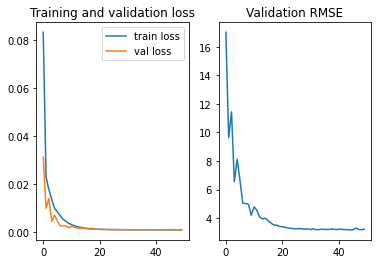

In [ ]:
if TRAIN_RUN:
    # model = NeuralNetwork()
    # model = model.to(device)
    # reset_network()
    # print(device)
    # model = model.to(device)
    train_model(dataloader, dataloader_val, EPOCHS_NUM)    

In [ ]:
# train_model(dataloader, dataloader_val, 10)    

In [ ]:
SAVED_MODEL_PATH = './FacialKeypointsDetector.pth'
if TRAIN_RUN:
    ## save model    
    torch.save(model, SAVED_MODEL_PATH)
    # torch.save(model.state_dict(), SAVED_MODEL_PATH)
else:
    # load model
    # model = NeuralNetwork()
    model.load_state_dict(torch.load(SAVED_MODEL_PATH))  
    # model = torch.load(SAVED_MODEL_PATH)
model.eval()  

NeuralNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_ru

###Explore Validation loss 


#### arrange the validation set in decending loss order

In [ ]:
## move the model to eval mode
GPU_FOR_TESTING = True
if GPU_FOR_TESTING:    
    # val_set = val_set.to(device)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pass
else:    
    device = 'cpu'
    
model.to(device)   
dataloader_val_analize = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0)

loss_list = []
for inx, sample in enumerate(dataloader_val_analize): # run over the mini batches            
    images, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']
    images, keysPts, mask = images.to(device), keysPts.to(device), mask.to(device)
    output = model(images).view(-1, 15, 2)       
    loss = 96*criterion(output, keysPts.float(), mask).item()**0.5            
    loss_list.append((inx, loss))

loss_list.sort(key = lambda image: image[1], reverse=True)
print(loss_list[:5])

[(519, 21.914988387024486), (591, 18.903057541350847), (137, 17.556094593244346), (1064, 16.120813047952215), (314, 9.29540167923016)]


In [ ]:
def show_keypoints(image, key_pts, pred_key_pts=None, mask=None):
    """Show image with keypoints and predicted keypoints"""
    if image.ndim == 3 and image.shape[0] > 1:
        if type(image) == torch.Tensor:
            plt.imshow(image.permute(1, 2, 0), )    
        else:
            plt.imshow(image.transpose(1,2,0), )    
    else:
        plt.imshow(image.squeeze(), cmap='gray',)  
    norm = image.shape[-1] if key_pts.flatten()[0] <= 1 else 1
    # plt.scatter(key_pts[:, 0]*norm, key_pts[:, 1]*norm, s=10, marker='.', c='m')
    if mask is not None:           
        key_pts = np.array([a for a, b in zip(key_pts.flatten(), mask.flatten()) if b]).reshape(-1,2)       
    plt.plot(key_pts[:, 0]*norm, key_pts[:, 1]*norm, '.', color='red', label='actual')
    if pred_key_pts is not None:
        plt.plot(pred_key_pts[:, 0]*norm, pred_key_pts[:, 1]*norm, '.', color='green', label='actual')
        

#### Validation set samples prediction vs ground truth
starting from the highest error validation samples

In [ ]:
def show_batch_images(dataset_list, batch_size=8, inorder=True):
    plt.figure(figsize=(20,8))
    # plt.figure()
    for i in range(min(len(dataset_list),batch_size)):        
        inx=i
        if not inorder: inx = random.randrange(len(dataset_list))
        sample = dataset_list[inx]
        image, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']    
        ax = plt.subplot(2, 8, i + 1)
        plt.tight_layout()
        ax.set_title(' #{} RMSE: {:.2f}'.format(i, loss_list[i][1]))
        ax.axis('off')            
        keyPtsPred = model(image.unsqueeze(0).to(device)).view(-1, 15, 2)        
        show_keypoints(image, keysPts ,keyPtsPred.squeeze(0).cpu().detach().numpy(), mask)        

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


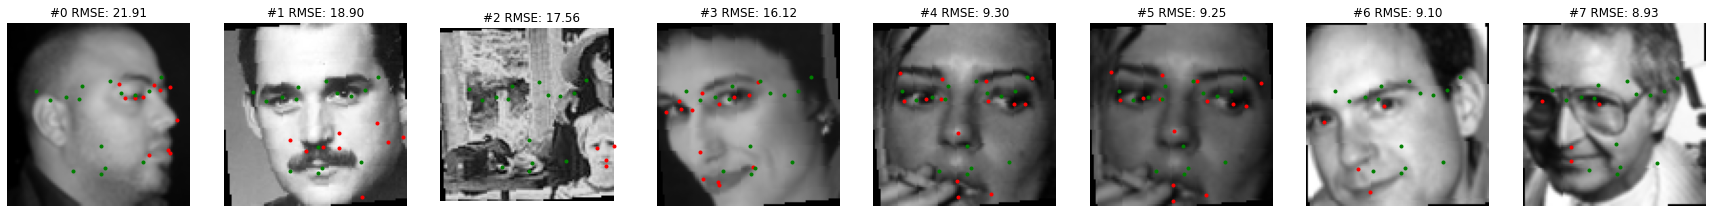

In [ ]:
model.eval()
plt.figure(figsize=(24,8))
# plt.figure()
for i in range(min(len(loss_list),8)):        
    inx = loss_list[i][0]
    sample = val_set[inx]
    image, keysPts, mask = sample['image'], sample['key_pts'], sample['mask']    
    ax = plt.subplot(2, 8, i + 1)
    plt.tight_layout()
    ax.set_title('#{} RMSE: {:.2f}'.format(i, loss_list[i][1]))
    ax.axis('off')        
    keyPtsPred = model(image.unsqueeze(0).to(device)).view(-1, 15, 2)    
    show_keypoints(image, keysPts ,keyPtsPred.squeeze(0).cpu().detach().numpy(), mask)        

plt.show()

### Test Model


In [ ]:
## on the first time
# !ls
# !unzip ./test.zip -d .

#### Extract the test dataset

In [ ]:
def create_test_dataset():
    test_csv_name = 'test.csv'
    test_df = pd.read_csv(test_csv_name)
    # len(test_df)
    test_ds = []
    for image_str in test_df['Image']:    
        im = image_str.split()
        test_ds.append([im,im,im]) # create each image as 3 channel image

    test_ds = np.array(test_ds,dtype=np.uint8)
    test_ds = test_ds.reshape(test_ds.shape[0],3,96,96)
    test_ds_torch = torch.from_numpy(test_ds).float()
    test_ds_torch /=255 # normalize    
    return test_ds, test_ds_torch

test_ds, test_ds_torch = create_test_dataset()

#### create predicitons for test set

In [ ]:
def create_test_results(test_model, test_tensor):    
    if GPU_FOR_TESTING:
        test_tensor = test_tensor.to(device)
        test_model.to(device)
    else:    
        test_model.to("cpu")
    test_model.eval()
    return test_model(test_tensor)

test_res = create_test_results(model, test_ds_torch)

#### Visualize Test images and predictions

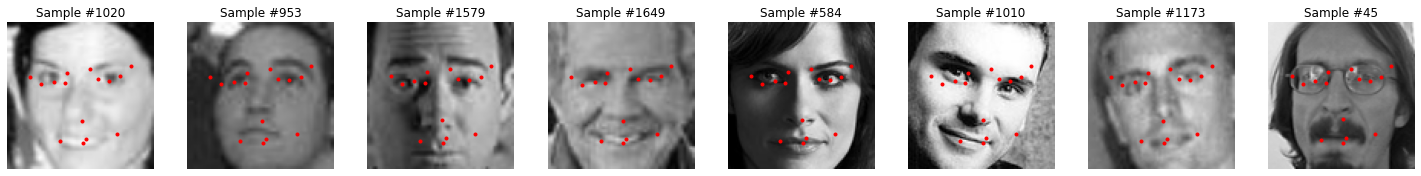

In [ ]:
fig = plt.figure(figsize=(20,8))
for i in range(len(test_res)):    
    img_inx = random.randrange(len(test_res))
    # print(i, test_ds[img_inx].shape, test_res[img_inx].cpu().data.numpy().shape)    
    ax = fig.add_subplot(1, 8, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(img_inx))
    ax.axis('off')    
    show_keypoints(test_ds[img_inx], test_res[img_inx].cpu().data.view(15,2).numpy())
    if i == 7: plt.show(); break

### creating submission file

In [ ]:
id_lookup = pd.read_csv('IdLookupTable.csv')
features = list(df.keys())[:-1] #list(id_lookup['FeatureName'][0:30])
features_dict = {feature:i for i,feature in enumerate(features)}

In [ ]:
def create_submission(results):
    test_res_flt = results.reshape(-1,2*15).cpu().data.numpy()
    test_res_flt *=96 # aligning to image size
    for row in range(len(id_lookup)):
        rowId = id_lookup['RowId'][row]
        # print(rowId)
        imageId = id_lookup['ImageId'][row]
        # print(imageId)
        featureName = id_lookup['FeatureName'][row]
        # print(featureName)
        featureNameinx = features_dict[featureName]
        # print(featureNameinx)
        # print(test_res_flt[imageId][featureNameinx])
        id_lookup['Location'][row] = test_res_flt[imageId-1][featureNameinx]              
    # id_lookup.head(5)

    submission = id_lookup[['RowId', 'Location']]
    submission.to_csv('Submission.csv', index=False)

create_submission(test_res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Kaggle score = 3.91314

## change model - pretrained resnet model
since the training loss is high, we change model to a more complex model - pretrained ResNet18

In [ ]:
model = resnet_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

[Epoch 1/50] -> train loss: 0.02106285  Validation Loss: 0.00107531; Validation RMSE: 3.1480
[Epoch 2/50] -> train loss: 0.00096466  Validation Loss: 0.00095389; Validation RMSE: 2.9650
[Epoch 3/50] -> train loss: 0.00092145  Validation Loss: 0.00092404; Validation RMSE: 2.9182
[Epoch 4/50] -> train loss: 0.00082458  Validation Loss: 0.00084148; Validation RMSE: 2.7848
[Epoch 5/50] -> train loss: 0.00077479  Validation Loss: 0.00082319; Validation RMSE: 2.7544
[Epoch 6/50] -> train loss: 0.00080125  Validation Loss: 0.00099556; Validation RMSE: 3.0290
[Epoch 7/50] -> train loss: 0.00073414  Validation Loss: 0.00328899; Validation RMSE: 5.5056
[Epoch 8/50] -> train loss: 0.00072273  Validation Loss: 0.00064264; Validation RMSE: 2.4336
[Epoch 9/50] -> train loss: 0.00066097  Validation Loss: 0.00064112; Validation RMSE: 2.4308
[Epoch 10/50] -> train loss: 0.00061936  Validation Loss: 0.00095315; Validation RMSE: 2.9638
[Epoch 11/50] -> train loss: 0.00062912  Validation Loss: 0.00072443;

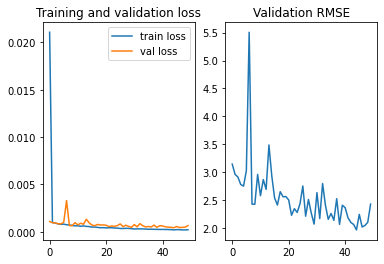

In [ ]:
train_model(dataloader, dataloader_val, EPOCHS_NUM)

In [ ]:
# model = resnet_model
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
# train_model(dataloader, dataloader_val, 50)

In [ ]:
# model??

In [ ]:
# test_res = create_test_result(model)
# model.to('cpu')
import gc

torch.save(model, SAVED_MODEL_PATH)

gc.collect()
torch.cuda.empty_cache() # avoid crash  

test_model = model
# test_model.to("cpu")
# test_model.eval()


In [ ]:
_, test_ds_torch = create_test_dataset()
# test_res = test_model(test_ds_torch[:100])
test_res = create_test_results(test_model, test_ds_torch)

create_submission(test_res)

print('done')

# _, test_ds_torch = create_test_dataset()
# # test_res = test_model(test_ds_torch[:100])
# test_res = create_test_results(test_model, test_ds_torch)
# # test_res = create_test_results(model)
# print('done')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


done


In [ ]:
# !cat /var/log/colab-jupyter.log
!ls /var/log/
# !cat /var/log/lastlog

alternatives.log  bootstrap.log  dpkg.log  fontconfig.log  lastlog   wtmp
apt		  btmp		 faillog   journal	   tallylog


In [ ]:
# create_submission(test_res)
# print('done')

#### Kaggle score = 

## Use custom loss function
with custom loss function the loss only refers to valid key points by setting all the non valid values to zero. 
This way we clear the noise from the training process.

[Epoch 1/50] -> train loss: 0.00168052  Validation Loss: 0.00057404; Validation RMSE: 2.3001
[Epoch 2/50] -> train loss: 0.00057521  Validation Loss: 0.00056095; Validation RMSE: 2.2737
[Epoch 3/50] -> train loss: 0.00048975  Validation Loss: 0.00051244; Validation RMSE: 2.1732
[Epoch 4/50] -> train loss: 0.00045524  Validation Loss: 0.00072311; Validation RMSE: 2.5815
[Epoch 5/50] -> train loss: 0.00042701  Validation Loss: 0.00044702; Validation RMSE: 2.0297
[Epoch 6/50] -> train loss: 0.00037520  Validation Loss: 0.00090339; Validation RMSE: 2.8854
[Epoch 7/50] -> train loss: 0.00038063  Validation Loss: 0.00097812; Validation RMSE: 3.0024
[Epoch 8/50] -> train loss: 0.00043337  Validation Loss: 0.00044951; Validation RMSE: 2.0354
[Epoch 9/50] -> train loss: 0.00027851  Validation Loss: 0.00039217; Validation RMSE: 1.9011
[Epoch 10/50] -> train loss: 0.00020549  Validation Loss: 0.00040042; Validation RMSE: 1.9210
[Epoch 11/50] -> train loss: 0.00026944  Validation Loss: 0.00037227;

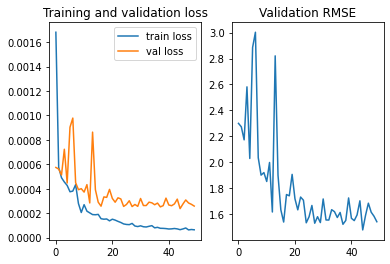

In [ ]:
def masked_MSELoss(pred, gt, mask):    
    pred = pred * mask
    gt = gt * mask    
    return torch_MSE(pred, gt)
criterion = masked_MSELoss

model = resnet_model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

train_model(dataloader, dataloader_val, EPOCHS_NUM)

In [ ]:
torch.save(model, SAVED_MODEL_PATH)

torch.cuda.empty_cache() # avoid crash

test_model = model
# test_model.to("cpu")
# test_model.eval()
_, test_ds_torch = create_test_dataset()
# test_res = test_model(test_ds_torch[:100])
test_res = create_test_results(test_model, test_ds_torch)

create_submission(test_res)
print('done')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


done


#### Kaggle score = 1.99/1.68 (public/private)

###problems:
* visualize the points on the image - use scatter
* conv2d with single channel image - use to_tensor transform
* nan result on the loss - use Adam optimizer
* inf values in the loss - normalize the output to [0,1]
* nan values in the csv - remove the nan lines
* test results out of image - normalize the data loader image values to [0,1] solved it 
* MSE criterion vs RMSE Kaggle score and output normalization

##phases:
###phase 1
* simple model
* no transforms
* 10 epochs
* first learning rate - 0.05
* first optimizer (Adam)
* batch size - 32
* outcome: validation error to 0.0012
* Kaggle score - 4.45

###phase 2
* split to training and validation 

###phase 3
* add transform transforms 
* blur
* 30 epocs
* Kaggle score - 4.31

###phase 3
* all before
* fill na using pandas ffill
* validation loss 0.0009
* Kaggle score - 4.17

###phase 3
* all before
* vertical and rotate transforms
* 8 epochs
* validation loss - 0.0009  
* Kaggle score - 4.17 

###phase 4
* all before
* brightness transform added
* 10 epochs
* validation loss - 0.0015
* Kaggle score - 4.216

###phase 5
* removed transforms
* model update - added dropouts to all layers
* 10 epochs
* training loss - 
* validation loss - 
* validation RMSE - 3.03
* Kaggle score - 

###phase 5
* removed transforms
* model update - resnet18 with transform learning
* 35 epochs
* training loss - 0.0002
* validation loss - 0.0006
* validation RMSE - 2.25
* Kaggle score - 2.8

###phase 5
* brightness transform only
* model update - resnet18 with transform learning
* 50 epochs
* training loss - 0.000174
* validation loss - 0.000393
* validation RMSE - 1.90
* Kaggle score - 2.41

###phase 6
* added masking for keypts
* 50 epochs
* training loss - 0.000049
* validation loss - 0.000231
* validation RMSE - 1.45
* Kaggle score - 1.98/1.71

